In [1]:
import sys
import os
sys.path.append('..')

In [2]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Solutions
from library.custom.custom_solutions import WSOGASolution
from library.data.relationship_matrix import relationship_matrix

# Operators
from library.algorithms.genetic_algorithms.algorithm import genetic_algorithm
from library.algorithms.genetic_algorithms.selection import fitness_proportionate_selection
from library.custom.custom_crossover import cycle_crossover, partially_matched_crossover, pos_based_crossover
from library.custom.custom_mutation import block_swap_mutation, n_swap_mutation, displacement_mutation, shuffle_subsequence_mutation
from library.custom.custom_selection import tournament_selection, ranking_selection

# Statistical Analysis
from scipy.stats import f_oneway
from library.custom.custom_stats_functions import load_fitness_results
from library.custom.custom_stats_functions import pairwise_ttest

# Utility functions

In [6]:
def plot_fitness_over_gen(fitness_dfs: dict[str, pd.DataFrame]):
    """
    
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    handles, labels = [], []

    for config_name, df in fitness_dfs.items():
        mean_fitness = df.mean(axis=0)
        median_fitness = df.median(axis=0)
        
        line1, = axes[0].plot(mean_fitness.index, mean_fitness.values, label=config_name)
        axes[1].plot(median_fitness.index, median_fitness.values, label=config_name)

        handles.append(line1)
        labels.append(config_name)

    axes[0].set_title("Mean Fitness Across Generations")
    axes[1].set_title("Median Fitness Across Generations")

    for ax in axes:
        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.grid(True)

    # Shared boxed legend below
    legend = fig.legend(
        handles,
        labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=2,
        frameon=True,
        borderpad=1
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    plt.show()

In [8]:
# for plotting fitness results by selection method
def extract_selection_method(config):
    if 'fitness_proportionate_selection' in config:
        return 'fitness_proportionate_selection'
    elif 'ranking_selection' in config:
        return 'ranking_selection'
    elif 'tournament_selection' in config:
        return 'tournament_selection'

# Global parameters

In [8]:
POP_SIZE = 50
GENERATIONS = 100
NBR_RUNS = 30

# Phase 1 Experiment: Configurations

In [ ]:
grid_params = {
    "crossover": [
        {
            "function": cycle_crossover,
            "xo_prob": 0.8
        },
        {
            "function": partially_matched_crossover,
            "xo_prob": 0.8
        },
        {
            "function": pos_based_crossover,
            "xo_prob": 0.8
        }
    ],
    "mutation": [
        {
            "function": block_swap_mutation,
            "mut_prob": 0.2
        },
        {
            # lower mutation probability than labs becuase n-swap is more disruptive than swap
            "function": n_swap_mutation,
            "mut_prob": 0.2
        },
        {
            "function": displacement_mutation,
            "mut_prob": 0.2
        },
        {
            "function": shuffle_subsequence_mutation,
            "mut_prob": 0.2
        }
    ],
    "selection": [tournament_selection, fitness_proportionate_selection, ranking_selection]
}

fitness_dfs = {}

# Generate all combinations of the grid parameters
grid = list(itertools.product(grid_params["crossover"], grid_params["mutation"], grid_params["selection"]))

for crossover_cfg, mutation_cfg, selection_algorithm in grid:
    # Create empty dataframe for each configuration
    # Columns have the fitness in each generation, rows will have results for each run
    df = pd.DataFrame(columns=range(GENERATIONS)) # Shape will be 30 x 100

    # Get crossover and mutation functions and probabilities from the grid
    crossover_function = crossover_cfg["function"]
    xo_prob = crossover_cfg["xo_prob"]
    mutation_function = mutation_cfg["function"]
    mut_prob = mutation_cfg["mut_prob"]

    # Run for predefined x times
    for run_nr in range(NBR_RUNS):
        _, fitness_over_gens = genetic_algorithm(
            initial_population=[
                WSOGASolution(
                    relationship_matrix=relationship_matrix,
                    mutation_function=mutation_function,
                    crossover_function=crossover_function,  
                ) for _ in range(POP_SIZE)
            ],
            max_gen=GENERATIONS,
            selection_algorithm=selection_algorithm,
            maximization=True,
            xo_prob=xo_prob,
            mut_prob=mut_prob,
            elitism=True
        )

        df.loc[run_nr] = fitness_over_gens

    # Create a label for the configuration
    config_label = (
        f"{crossover_function.__name__}{xo_prob}_"
        f"{mutation_function.__name__}{mut_prob}_"
        f"{selection_algorithm.__name__}"
    )

    # Save configuration results in the dictionary
    fitness_dfs[config_label] = df

    # creating an output directory to save experiment results
    output_dir = "phase1_fitness_results"
    os.makedirs(output_dir, exist_ok=True)

    # saving each configuration result as a CSV
    df.to_csv(os.path.join(output_dir, f"{config_label}.csv"), index=False)

In [12]:
print(list(fitness_dfs.keys()))

['cycle_crossover0.8_block_swap_mutation0.2_tournament_selection', 'cycle_crossover0.8_block_swap_mutation0.2_fitness_proportionate_selection', 'cycle_crossover0.8_block_swap_mutation0.2_ranking_selection', 'cycle_crossover0.8_n_swap_mutation0.2_tournament_selection', 'cycle_crossover0.8_n_swap_mutation0.2_fitness_proportionate_selection', 'cycle_crossover0.8_n_swap_mutation0.2_ranking_selection', 'cycle_crossover0.8_displacement_mutation0.2_tournament_selection', 'cycle_crossover0.8_displacement_mutation0.2_fitness_proportionate_selection', 'cycle_crossover0.8_displacement_mutation0.2_ranking_selection', 'cycle_crossover0.8_shuffle_subsequence_mutation0.2_tournament_selection', 'cycle_crossover0.8_shuffle_subsequence_mutation0.2_fitness_proportionate_selection', 'cycle_crossover0.8_shuffle_subsequence_mutation0.2_ranking_selection', 'partially_matched_crossover0.8_block_swap_mutation0.2_tournament_selection', 'partially_matched_crossover0.8_block_swap_mutation0.2_fitness_proportionate

In [ ]:
# viewing one configuration results
fitness_dfs["partially_matched_crossover0.8_displacement_mutation0.2_ranking_selection"]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,22500,22500,26100,26100,26100,26100,32200,32200,32200,32300,...,42100,42100,42100,42100,42100,43100,43100,43100,43100,43100
1,22600,25100,26400,28500,34500,34500,34500,34500,34500,34500,...,49400,49400,49400,49400,49400,49400,49400,49400,49400,49400
2,24900,25900,25900,25900,28100,30000,30000,30000,33500,33900,...,43900,43900,43900,43900,43900,43900,44400,44400,44400,44400
3,25600,25600,25600,25600,25600,25900,25900,29600,29600,30200,...,46200,46200,46200,47900,47900,47900,47900,47900,47900,47900
4,21500,25700,25700,25700,25800,25800,26700,26700,26700,27400,...,42400,42400,42400,42400,42400,42400,42400,42400,42400,42400
5,24000,24000,24000,24200,28400,28400,30200,30800,30800,30800,...,49500,49500,49500,49500,49500,49500,49500,49500,49500,49500
6,25800,29300,29300,29300,29300,29300,29300,29300,29300,32400,...,51500,51500,51500,51500,51500,51500,51500,51500,51500,51500
7,24800,24800,27700,27700,27700,29100,29100,38000,38000,38000,...,46400,46400,46400,46400,46400,46400,46400,46400,46400,46400
8,21300,21600,22100,22900,24400,24400,26200,29800,29800,29800,...,56200,56200,56200,56200,56200,56200,56200,56200,56200,56200
9,20000,25100,25100,25100,25100,26900,26900,26900,27200,30100,...,41600,41600,41600,41600,41600,41600,41600,41600,41600,41600


Top 8 configurations sorted desc:
partially_matched_crossover0.8_n_swap_mutation0.2_ranking_selection: 48096.666666666664
cycle_crossover0.8_n_swap_mutation0.2_ranking_selection: 47213.333333333336
partially_matched_crossover0.8_displacement_mutation0.2_ranking_selection: 47053.333333333336
pos_based_crossover0.8_shuffle_subsequence_mutation0.2_tournament_selection: 46910.0
partially_matched_crossover0.8_shuffle_subsequence_mutation0.2_ranking_selection: 46816.666666666664
partially_matched_crossover0.8_n_swap_mutation0.2_tournament_selection: 46566.666666666664
partially_matched_crossover0.8_shuffle_subsequence_mutation0.2_tournament_selection: 46386.666666666664
pos_based_crossover0.8_shuffle_subsequence_mutation0.2_ranking_selection: 45666.666666666664


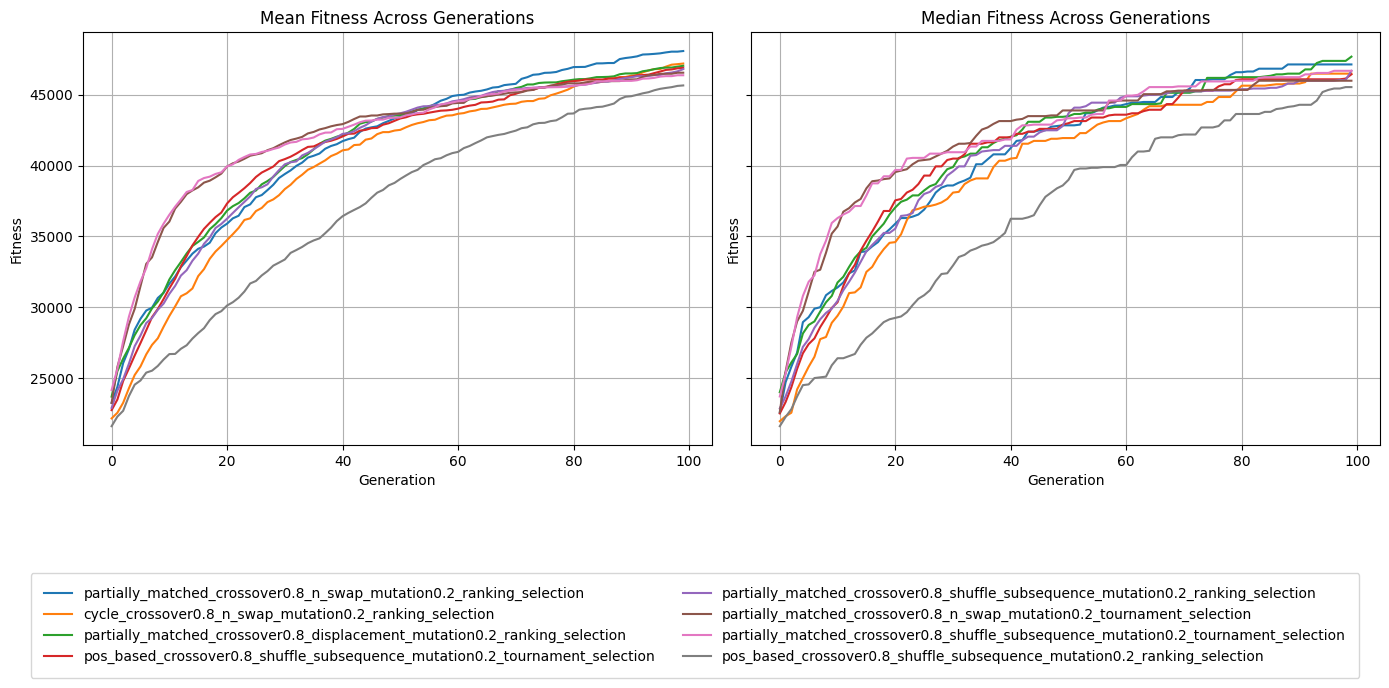

In [ ]:
# Select the top 8 configurations with the highest mean fitness in the last generation
last_gen_fitness = {
    config: df[GENERATIONS - 1].mean() for config, df in fitness_dfs.items()
}

# Sort descending and take the top 8
top_configs = sorted(last_gen_fitness, key=last_gen_fitness.get, reverse=True)[:8]

print("Top 8 configurations, sorted descending order:")
for config in top_configs:
    print(f"{config}: {last_gen_fitness[config]}")

# Dictionary for plotting
top_fitness_dfs = {config: fitness_dfs[config] for config in top_configs}
plot_fitness_over_gen(top_fitness_dfs)

# Analysis of Experiment Results  

To analyze which of our configurations to carry on into the hyperparameter tuning phase, we ran the above experiment twice. We then concatenated the results, allowing us to analyze 60 runs of each configuration. Results are loaded and analyzed below.

In [3]:
# using loader function to get fitness values from CSVs (for ANOVA test)
fitness_by_configuration = load_fitness_results('fitness_results/phase1_concatenated')

# using longform loader function to get fitness values from CSVs (for plotting and pairwise tests)
longform_fitness = load_fitness_results('fitness_results/phase1_concatenated', longform=True)

In [4]:
# sorting configurations in descending order by highest fitness
sorted_configs = sorted(fitness_by_configuration.items(), key=lambda x: np.mean(x[1]), reverse=True)

top_sorted_configs = sorted_configs[:8]
bottom_sorted_configs = sorted_configs[-8:]

In [5]:
# print name and mean fitness of top configurations
print('Top 8 configurations:')
for config, values in top_sorted_configs:
    mean_val = sum(values) / len(values)
    print(f"{config}: mean fitness = {mean_val:.2f}")

Top 8 configurations:
cycle_crossover0.8_n_swap_mutation0.2_ranking_selection: mean fitness = 47586.67
partially_matched_crossover0.8_displacement_mutation0.2_ranking_selection: mean fitness = 47480.00
partially_matched_crossover0.8_n_swap_mutation0.2_ranking_selection: mean fitness = 47426.67
partially_matched_crossover0.8_shuffle_subsequence_mutation0.2_ranking_selection: mean fitness = 47153.33
partially_matched_crossover0.8_shuffle_subsequence_mutation0.2_tournament_selection: mean fitness = 46775.00
pos_based_crossover0.8_shuffle_subsequence_mutation0.2_tournament_selection: mean fitness = 46220.00
pos_based_crossover0.8_shuffle_subsequence_mutation0.2_ranking_selection: mean fitness = 45940.00
partially_matched_crossover0.8_n_swap_mutation0.2_tournament_selection: mean fitness = 45778.33


In [6]:
# print name and mean fitness of bottom configurations
print('Bottom 8 configurations:')
for config, values in bottom_sorted_configs:
    mean_val = sum(values) / len(values)
    print(f"{config}: mean fitness = {mean_val:.2f}")

Bottom 8 configurations:
pos_based_crossover0.8_block_swap_mutation0.2_ranking_selection: mean fitness = 37283.33
partially_matched_crossover0.8_block_swap_mutation0.2_tournament_selection: mean fitness = 37263.33
pos_based_crossover0.8_shuffle_subsequence_mutation0.2_fitness_proportionate_selection: mean fitness = 36125.00
pos_based_crossover0.8_displacement_mutation0.2_fitness_proportionate_selection: mean fitness = 35331.67
pos_based_crossover0.8_block_swap_mutation0.2_tournament_selection: mean fitness = 33501.67
cycle_crossover0.8_block_swap_mutation0.2_fitness_proportionate_selection: mean fitness = 30493.33
cycle_crossover0.8_block_swap_mutation0.2_ranking_selection: mean fitness = 30386.67
cycle_crossover0.8_block_swap_mutation0.2_tournament_selection: mean fitness = 28150.00


### Visualization of Phase 1 Best Configuration

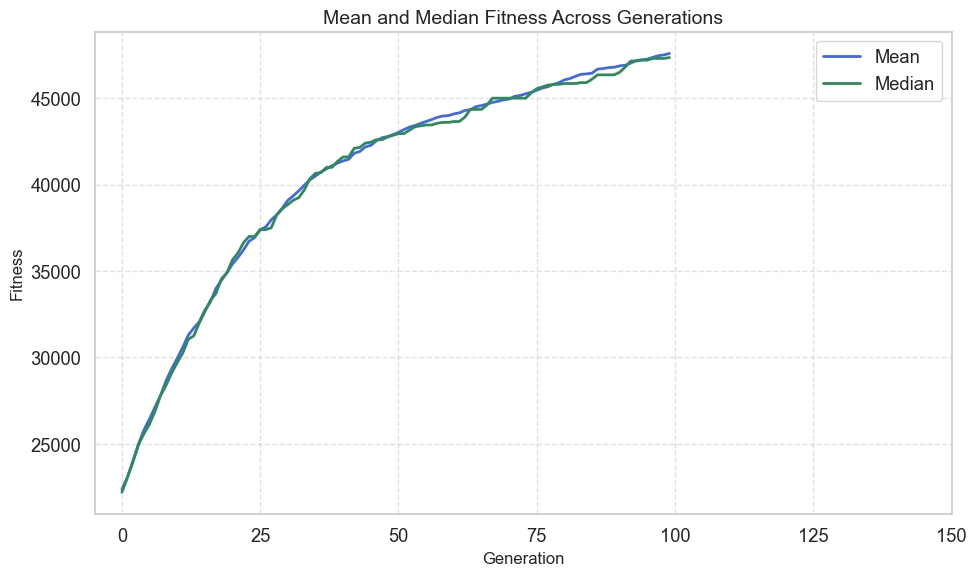

In [13]:
best_fitness_df = pd.read_csv("fitness_results/phase1_concatenated/cycle_crossover0.8_n_swap_mutation0.2_ranking_selection.csv")

best_fitness_df.columns = best_fitness_df.columns.astype(int)

# computing mean and median across runs (rows)
mean_fitness = best_fitness_df.mean(axis=0)
median_fitness = best_fitness_df.median(axis=0)

plt.figure(figsize=(10, 6))

plt.plot(mean_fitness.index, mean_fitness.values, label="Mean", color='royalblue', linewidth=2)
plt.plot(median_fitness.index, median_fitness.values, label="Median", color='seagreen', linewidth=2)

# Customize
plt.title("Mean and Median Fitness Across Generations", fontsize=14)
plt.xlabel("Generation", fontsize=12)
plt.ylabel("Fitness", fontsize=12)
plt.xticks(range(0, 151, 25))  # Tick every 25 generations
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

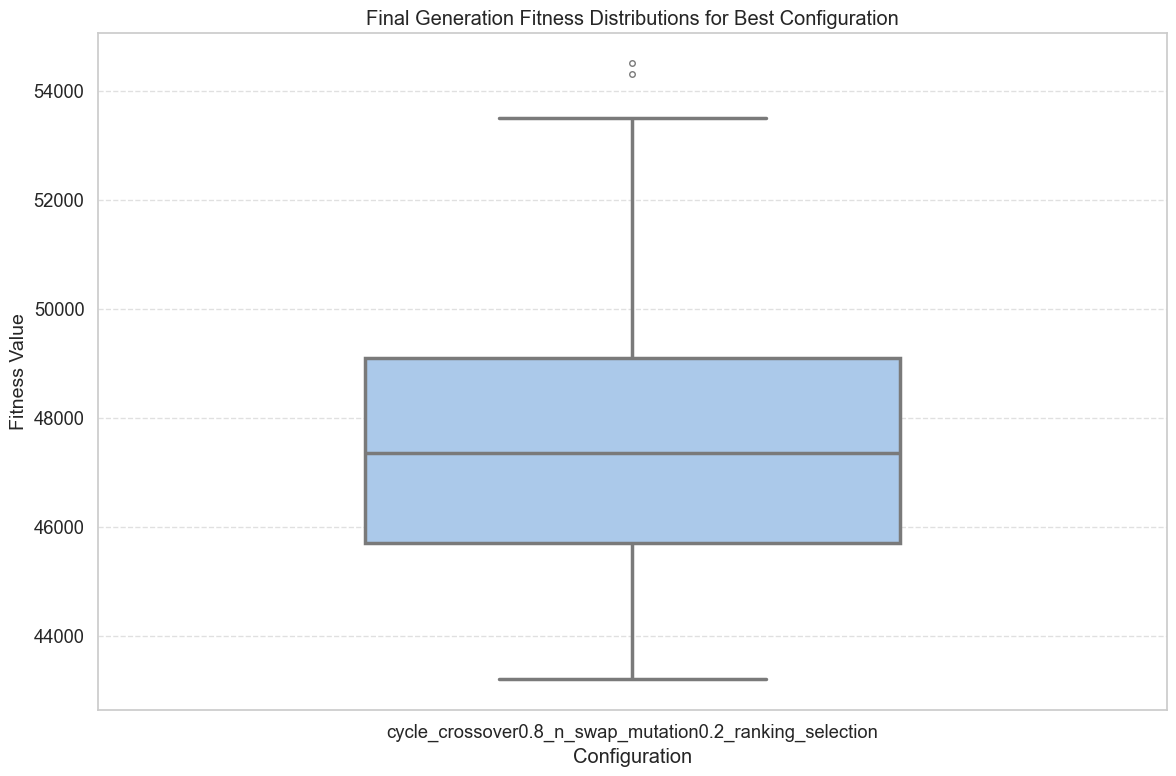

In [14]:
# Set a beautiful theme using Seaborn
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.2)

# Create the plots - one for each selection method for readibility
plt.figure(figsize=(12, 8))
data = longform_fitness[longform_fitness['configuration'] == 'cycle_crossover0.8_n_swap_mutation0.2_ranking_selection']

ax = sns.boxplot(x='configuration', y='fitness_value', data=data, width=0.5, linewidth=2.5, fliersize=4)

# Titles and labels
plt.title(f'Final Generation Fitness Distributions for Best Configuration')
plt.ylabel('Fitness Value', fontsize=14)
plt.xlabel('Configuration')
plt.xticks(rotation=0)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

## Statistical Analysis

We will run an ANOVA difference in means statistical test to determine which configuration, if any, has statistically significantly better results than the others.   
  
ANOVA is used to test if variation of means BETWEEN groups is large compared to variation of means WITHIN groups. To do this, an ANOVA test compares the Mean Squared Error (MSE; weighted average of within-gropup variability) with the Mean Squared Treatments (MST; weighted average of between-group variability).  Our statistical hypotheses are as follows:  
 - H_0: mean_1 = mean_2 = mean_3 = ... = mean_n (for i in range (0, n) where each mean_i is a configuration)
 - H_a: at least one mean is different from the others  
   

The ANOVA test will calculate an F-statistic of F_s = MST/MSE.  
- If MST >> MSE, then F_s is big, we reject H_0, and there is a large difference in the means of the groups.
- On the contrary, if MST << MSE, then F_s is small, we fail to reject H_0, and there is not much difference between the means of the groups.  
  
This ANOVA test will simply indicate IF one of the means in the group is significantly different from the others. We will perform a post-hoc test to determine WHICH of the means it is.  

#### Assumptions of ANOVA
- Groups are independent: Somewhat. Configurations have shared attributes that may limit independence.
- Observations are random samples: Yes. We are 'randomly sampling' the entire population of each configuration.
- Group popualtion distributions are approximately normal: Yes. Safe to assume because for each configuration, n = 60.
- Group standard deviations are approximately equal: Unknown. We will plot boxplots to make an informal decision.

Source: Wackerly, Dennis D., William Mendenhall, and Richard L. Scheaffer. Mathematical Statistics with Applications. 7th ed., Thomson Brooks/Cole, 2008.

### Examining fitness distributions among configurations

Before running our ANOVA test, we will examine the distributions of mean final generation fitness in our configurations. Visualizations are plotted by selection type.

/var/folders/jn/44d5fkln1_70h9nxyc2t9d3r0000gp/T/ipykernel_40613/11966723.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


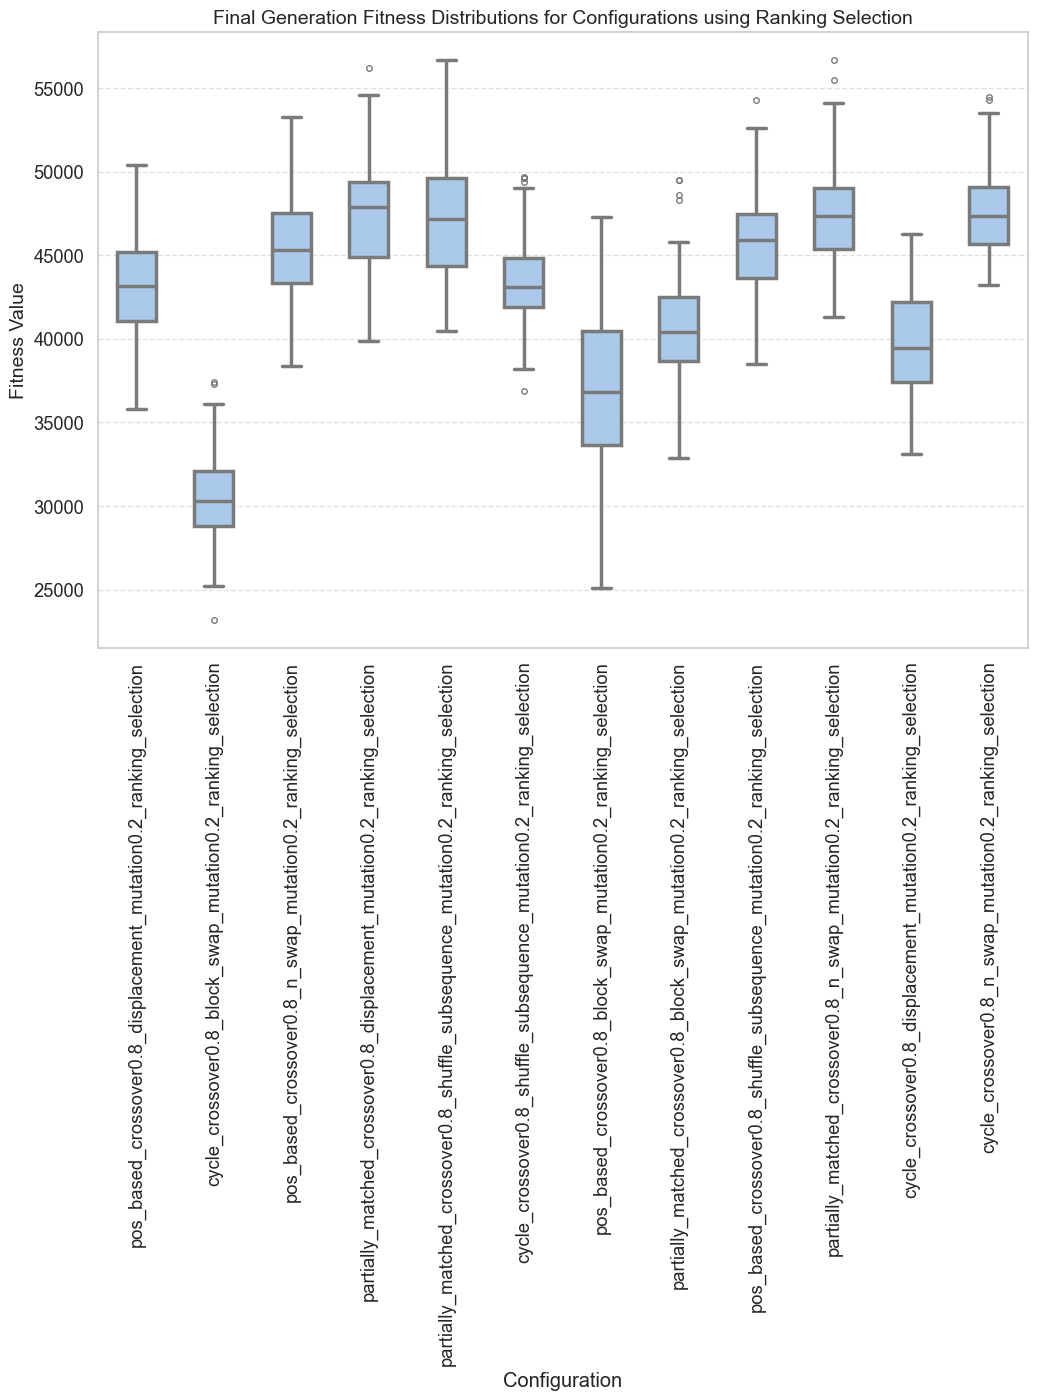

/var/folders/jn/44d5fkln1_70h9nxyc2t9d3r0000gp/T/ipykernel_40613/11966723.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


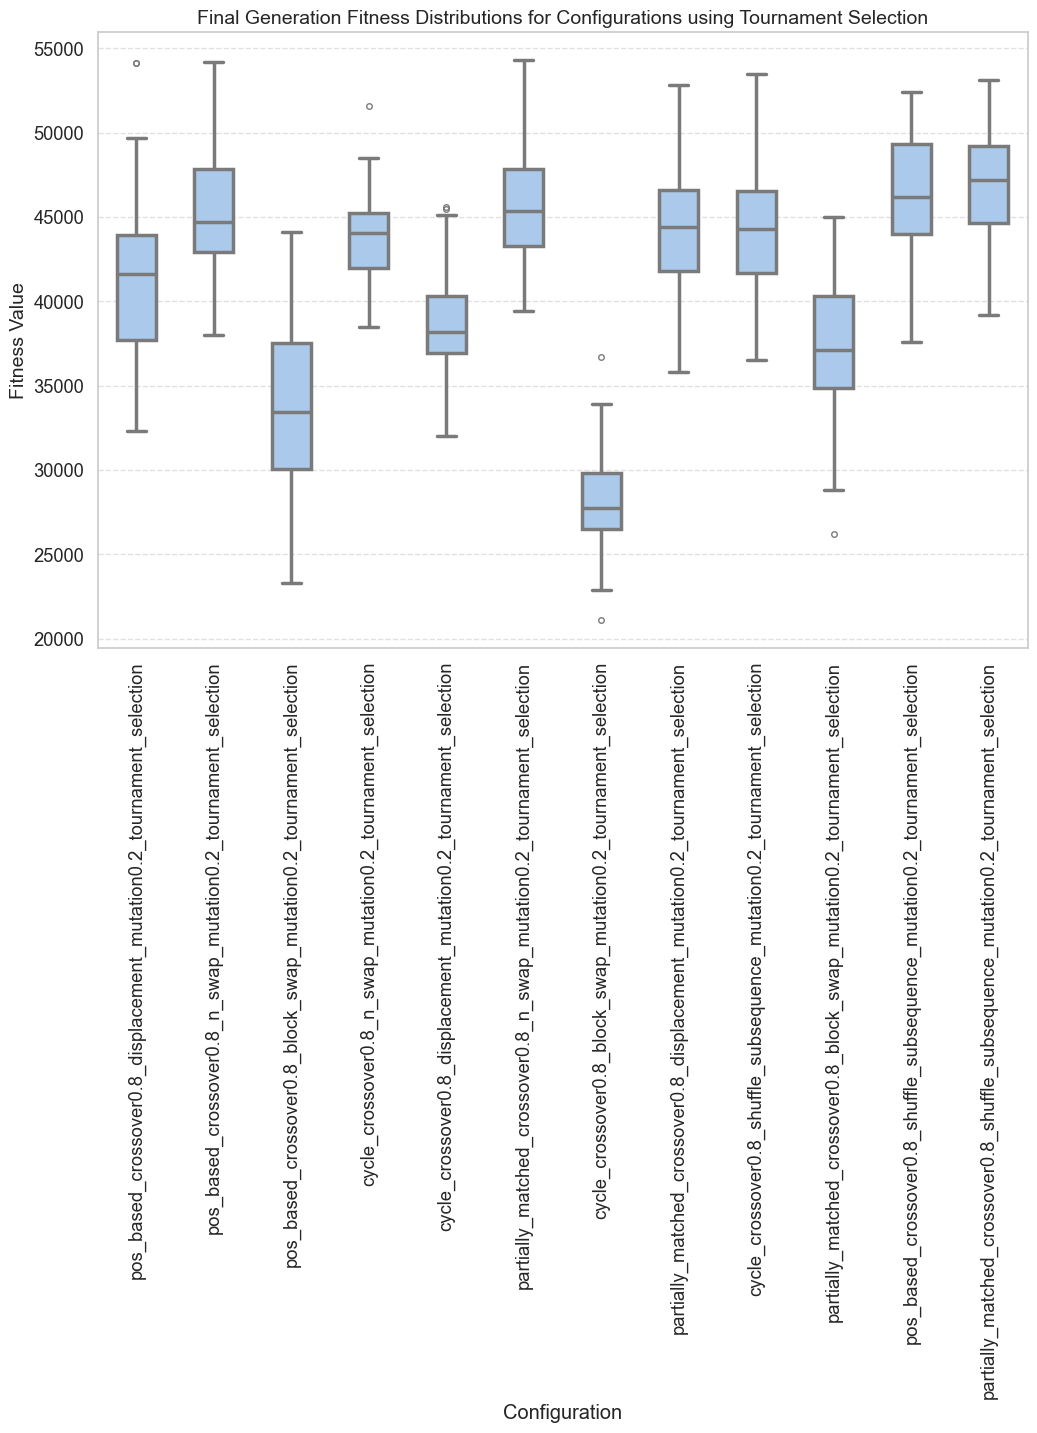

/var/folders/jn/44d5fkln1_70h9nxyc2t9d3r0000gp/T/ipykernel_40613/11966723.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


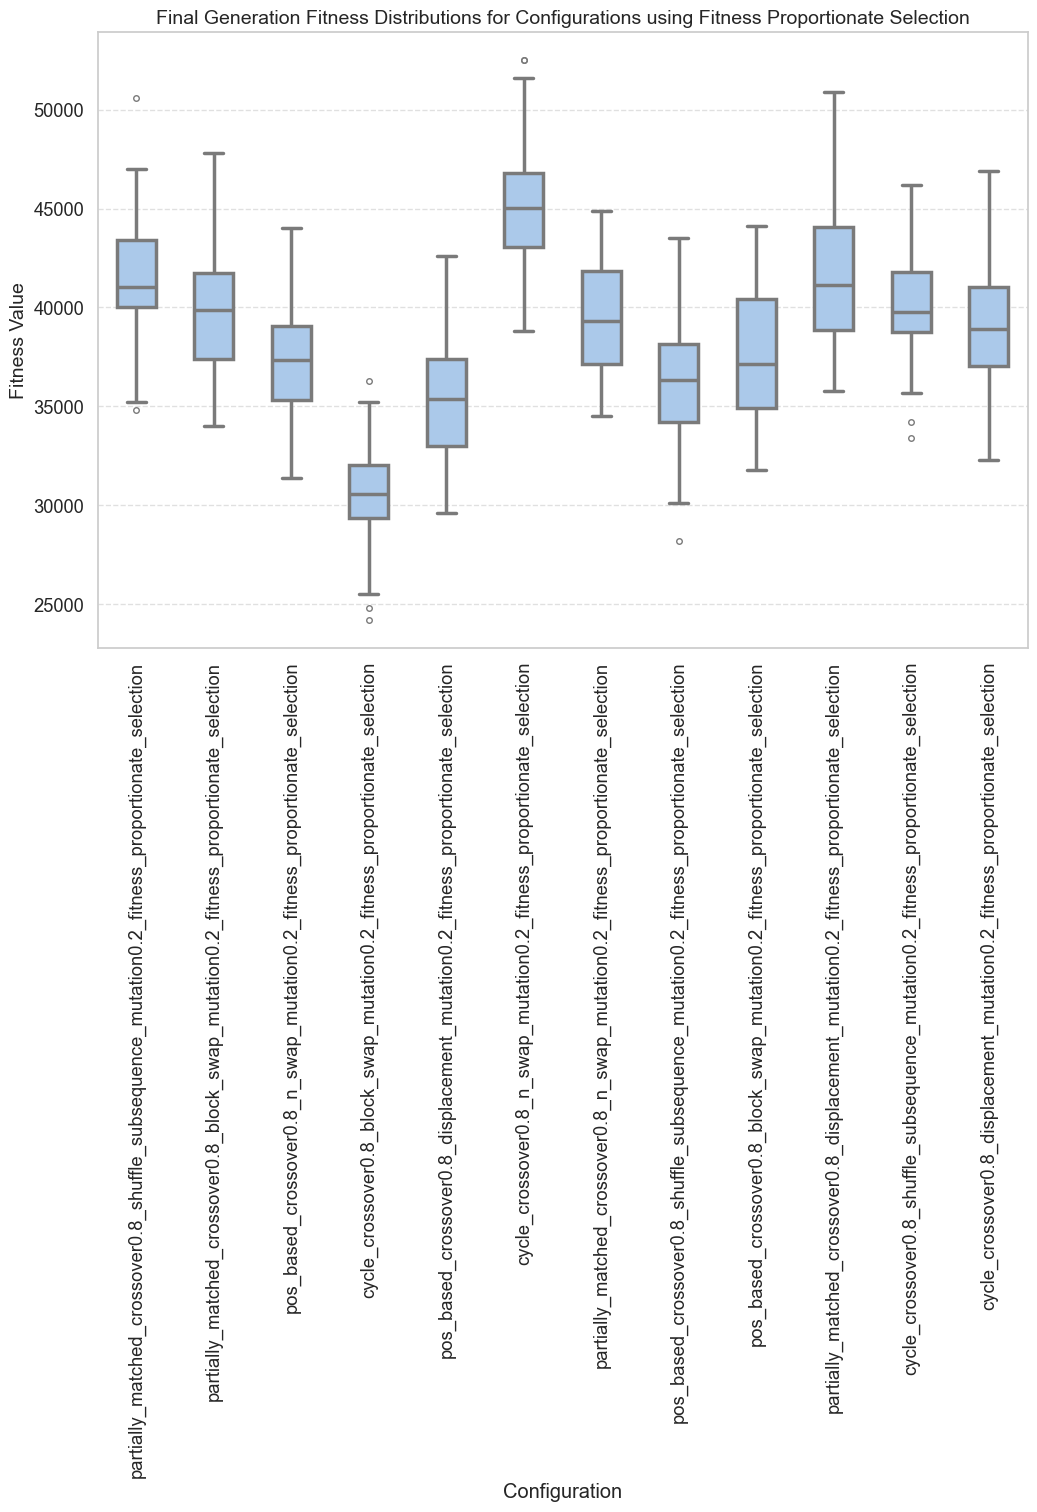

In [9]:
# Set a beautiful theme using Seaborn
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.2)

longform_fitness['selection_method'] = longform_fitness['configuration'].apply(extract_selection_method)

# Create the plots - one for each selection method for readibility
for method in longform_fitness['selection_method'].unique():
    plt.figure(figsize=(12, 8))
    data_subset = longform_fitness[longform_fitness['selection_method'] == method]

    ax = sns.boxplot(x='configuration', y='fitness_value', data=data_subset, width=0.5, linewidth=2.5, fliersize=4)

    # Titles and labels
    plt.title(f"Final Generation Fitness Distributions for Configurations using {method.replace('_', ' ').title()}", fontsize=14)
    plt.ylabel('Fitness Value', fontsize=14)
    plt.xlabel('Configuration')
    plt.xticks(rotation=90)
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


### Boxplot Analysis

#### Visual observations
From the plots above, we see that configurations using Ranking Selection consistently outperform configurations using Tournament or Fitness Proportionate Selection. It also appears that all combinations involving Block Swap mutation perform worse than configurations using other mutation methods. On the contrary, it appears that N-Swap mutation gives consistently high fitness results.  

#### Implications for statistical tests
We can see that most configurations have a relatively normal distribution, with few outliers and centered median. This is to be expected, as sample size for each configuration is 60. As the distributions are relatively normal, and the range of Quartile 1 to Quartile 3 are generally consistent across distributions, we can informally assume that the standard deviations of the configurations are approximately equal. (IQR represents middle 50% of data, one standard deviation represents ~68% of data). Given more time, we would formally assess the distribution of standard deviations to ensure all assumptions for ANOVA are valid. For now, we proceed with our informal analysis and will proceed with ANOVA statistical test.

### ANOVA test for difference in means

In [10]:
# converts fitness values of each config into a list for ANOVA
groups = list(fitness_by_configuration.values())

# ANOVA test
f_stat, p_value = f_oneway(*groups)

print('F-statistic:', f_stat)
print('p-value:', p_value)

# interpreting results:
if p_value <= 0.05:
    print('There is statistical evidence to suggest that the mean final genertion fitness of at least one configuration is different than the others.')
else:
    print('There is no statistical evidence to suggest that the mean final genertion fitness of one configuration is different than the others.')

F-statistic: 140.9555432884898
p-value: 0.0
There is statistical evidence to suggest that the mean final genertion fitness of at least one configuration is different than the others.


### Pos-Hoc tests for ANOVA: Pairwise T-Test  

The following test is to determine if the mean final geneartion fitness of our best perfomring configuration (cycle_crossover0.8_n_swap_mutation0.2_ranking_selection) is statistically significantly higher than other configurations we tested. Using ScipyStats t-test, we conduct a pairwise test on our best configuration against all others.

In [11]:
# running pairwise t-test on best config vs. all others
phase1_ttest = pairwise_ttest(longform_fitness, 'cycle_crossover0.8_n_swap_mutation0.2_ranking_selection')

# view results
phase1_ttest

,compared_to,mean_best,mean_other,mean_diff,p_value,significant
24,cycle_crossover0.8_block_swap_mutation0.2_tour...,47586.666667,28150.000000,19436.666667,1.249157e-68,True
12,cycle_crossover0.8_block_swap_mutation0.2_fitn...,47586.666667,30493.333333,17093.333333,2.429535e-65,True
2,cycle_crossover0.8_block_swap_mutation0.2_rank...,47586.666667,30386.666667,17200.000000,6.476709e-62,True
14,pos_based_crossover0.8_displacement_mutation0....,47586.666667,35331.666667,12255.000000,7.926704e-46,True
19,pos_based_crossover0.8_shuffle_subsequence_mut...,47586.666667,36125.000000,11461.666667,1.941760e-42,True
8,pos_based_crossover0.8_block_swap_mutation0.2_...,47586.666667,33501.666667,14085.000000,8.405934e-41,True
11,pos_based_crossover0.8_n_swap_mutation0.2_fitn...,47586.666667,37408.333333,10178.333333,1.782577e-39,True
28,pos_based_crossover0.8_block_swap_mutation0.2_...,47586.666667,37428.333333,10158.333333,5.916289e-37,True
17,cycle_crossover0.8_displacement_mutation0.2_to...,47586.666667,38621.666667,8965.000000,5.244256e-33,True
34,cycle_crossover0.8_displacement_mutation0.2_fi...,47586.666667,38888.333333,8698.333333,1.178191e-32,True


In [12]:
# viewing only configurations that are not significant
phase1_ttest[phase1_ttest['significant'] == False]

,compared_to,mean_best,mean_other,mean_diff,p_value,significant
35,partially_matched_crossover0.8_shuffle_subsequ...,47586.666667,46775.000000,811.666667,0.066462,False
10,partially_matched_crossover0.8_shuffle_subsequ...,47586.666667,47153.333333,433.333333,0.228913,False
23,partially_matched_crossover0.8_n_swap_mutation...,47586.666667,47426.666667,160.000000,0.383259,False
7,partially_matched_crossover0.8_displacement_mu...,47586.666667,47480.000000,106.666667,0.425657,False
33,cycle_crossover0.8_n_swap_mutation0.2_ranking_...,47586.666667,47586.666667,0.000000,0.500000,False


### Statistical Conclusion  
While the mean of our best performing configuration is statistically significantly higher than the mean of many of our other combinations, there are four combinations that are not significantly different. Interestingly, the other top performers differ in many ways: three of five use Partially Matched Crossover rather than Cycle Crossover. Shuffle Subsequence, N Swap, and Displament Mutations are all present in the other high-performing configurations.

Given more time, we would have explored hyperparameter tuning on the four additional configurations that are not statistically different than our best perfoming configuration.  
  
Despite the lack of statistical significance in this case, we will continue our experiment with this configuration.